In [620]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #untuk standarisasi
from sklearn.preprocessing import LabelEncoder # untuk label encoding
import sklearn # untuk data splitting
from sklearn.model_selection import train_test_split # untuk data splitting
from sklearn import linear_model # *algoritma Least Angle Regression
from sklearn.linear_model import LinearRegression # *algoritma Linear Regression
from sklearn.ensemble import GradientBoostingRegressor # *algoritma Gradient Boosting Regressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # untuk evaluasi model regresi
import joblib # untuk menyimpan model
import pickle # untuk menyimpan model
import numpy as np



In [621]:
print(sklearn.__version__)
print(joblib.__version__)
print(numpy.__version__)

1.6.1
1.4.2
2.1.3


In [622]:
df = pd.read_csv("../data/dirty_cafe_sales.csv")

In [623]:
df.head()  # menampilkan 5 baris pertama

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,NaN,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [624]:
df.shape  # (jumlah_baris, jumlah_kolom)

(10000, 8)

In [625]:
df.describe(include="all")  # ringkasan statistik

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9666,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


# Mengatasi Missing Value

In [626]:
# Cek data jumlah data hilang
missing_value = df.isnull().sum()
missing_value[missing_value > 0] # cek data array missing value yang lebih dari 0

Item                 334
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [627]:
# Pertama-tama, mari kita pisahkan kolom yang memiliki missing value lebih dari 75% dan kurang dari 75%.
less = missing_value[missing_value < 1000].index # indexnya diambil dengan .index
more = missing_value[missing_value >= 1000].index

In [628]:
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent',
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [629]:
# Contoh mengisi nilai yang hilang dengan median untuk kolom numerik
numeric_features = df[less].select_dtypes(include=["number"]).columns # Mengambil kolom yang bertipe numeric
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median()) # mengisi kolom numeric dengan median dari kolom numeric
print(numeric_features)
# print(less)
# print(df[less].dtypes)

# Baris pertama memilih nama-nama kolom dari DataFrame df yang memiliki tipe data numerik dari subset kolom yang ditentukan oleh less.

# Baris kedua kemudian mengisi semua nilai yang hilang (NaN) pada kolom-kolom numerik tersebut dengan nilai median dari masing-masing kolom.

Index(['Quantity', 'Price Per Unit', 'Total Spent'], dtype='object')


## Mengisi Missing Value Pada String

In [630]:
# Contoh mengisi nilai yang hilang dengan mode/modulus untuk kolom kategori 
kategorical_features = df.select_dtypes(include=['object']).columns # Mengambil missing value pada kolom bertipe object
print(kategorical_features)

for collum in kategorical_features:
    df[collum] = df[collum].replace(["UNKNOWN", "ERROR", ""], np.nan) # Mengubah string "UNKNOWN atau ERROR menjadi nan agar dapat di fill dengan modulus"
    df[collum] = df[collum].fillna(df[collum].mode()[0]) # ambil index pertama dari modulus .mode()[0]

Index(['Transaction ID', 'Item', 'Payment Method', 'Location',
       'Transaction Date'],
      dtype='object')


In [631]:
df.isnull().sum()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

In [632]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              10000 non-null  object 
 2   Quantity          10000 non-null  float64
 3   Price Per Unit    10000 non-null  float64
 4   Total Spent       10000 non-null  float64
 5   Payment Method    10000 non-null  object 
 6   Location          10000 non-null  object 
 7   Transaction Date  10000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


In [633]:
# Menghapus kolom dengan banyak data missing
# gunakan variable baru agar dapat dibandingkan dengan data yang lama
# new_df = df.drop(columns=more)

new_df = df.drop(columns=['Transaction ID', 'Transaction Date'])

In [634]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Juice,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,8.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [635]:
new_df.head()

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location
0,Juice,2.0,2.0,4.0,Credit Card,Takeaway
1,Cake,4.0,3.0,12.0,Cash,In-store
2,Cookie,4.0,1.0,8.0,Credit Card,In-store
3,Salad,2.0,5.0,10.0,Digital Wallet,Takeaway
4,Coffee,2.0,2.0,4.0,Digital Wallet,In-store


In [636]:
missing_value = new_df.isnull().sum()
missing_value[missing_value > 0]

Series([], dtype: int64)

# Mengatasi Outliers

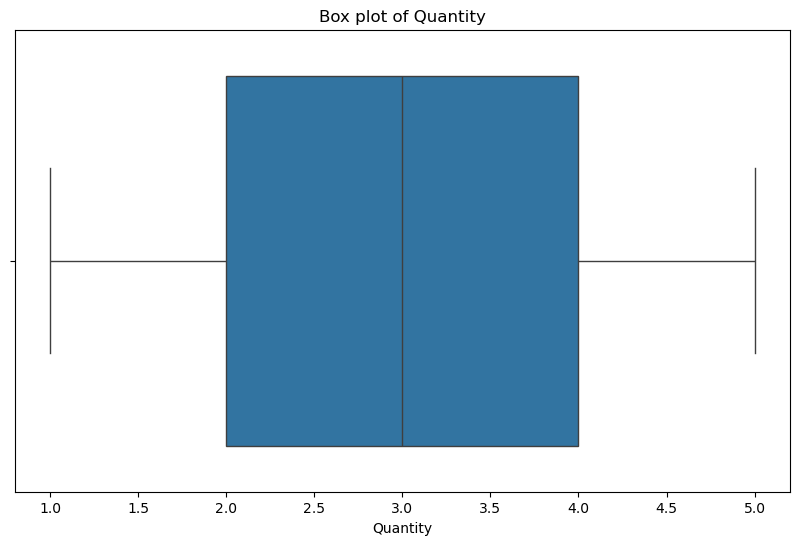

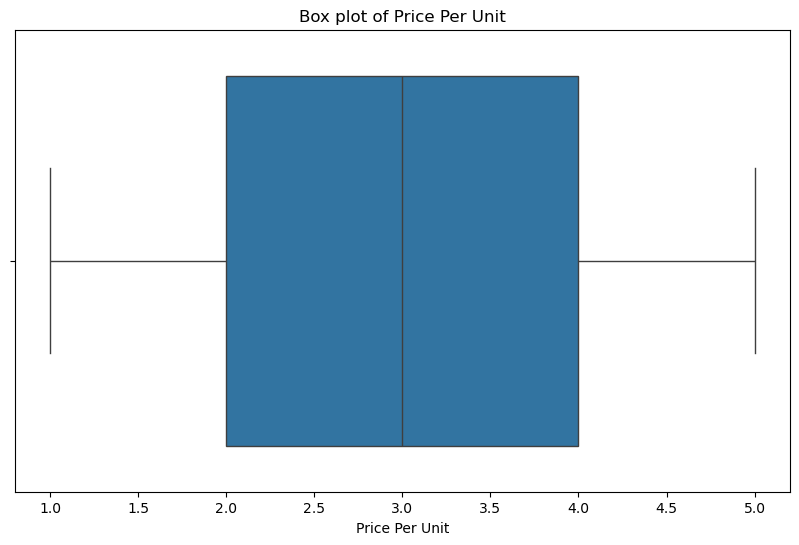

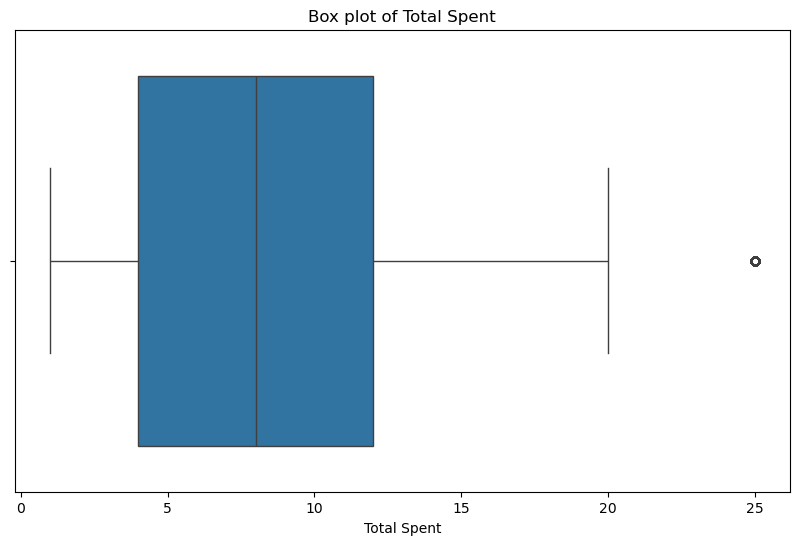

In [637]:
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=new_df[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()

In [638]:
# Contoh sederhana untuk mengidentifikasi outliers menggunakan IQR
Q1 = new_df[numeric_features].quantile(0.25)
Q3 = new_df[numeric_features].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Quantity          2.0
Price Per Unit    2.0
Total Spent       8.0
dtype: float64


In [639]:
# Filter dataframe untuk hanya menyimpan baris yang tidak mengandung outliers pada kolom numerik
condition = ~((new_df[numeric_features] < (Q1 - 1.5 * IQR)) | (new_df[numeric_features] > (Q3 + 1.5 * IQR))).any(axis=1)
df_filtered_numeric = new_df.loc[condition, numeric_features]

In [640]:
# Menggabungkan kembali dengan kolom kategorikal
categorical_features = new_df.select_dtypes(include=['object']).columns
new_df = pd.concat([df_filtered_numeric, new_df.loc[condition, categorical_features]], axis=1)

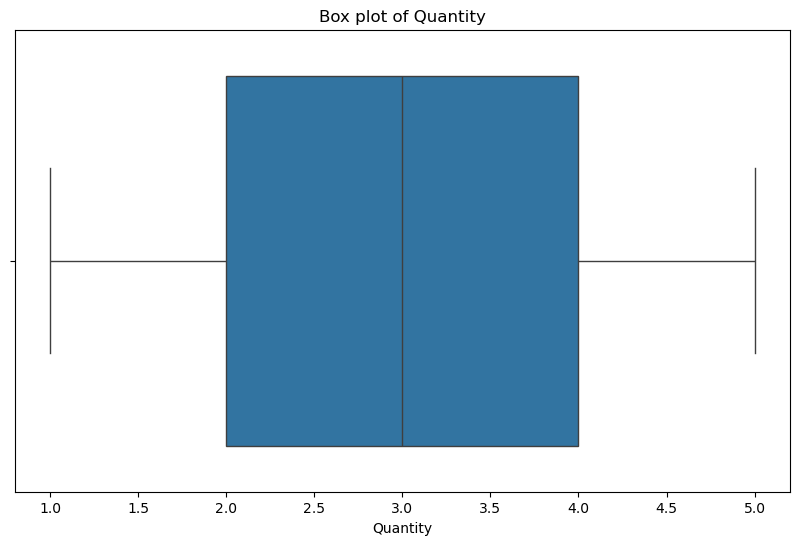

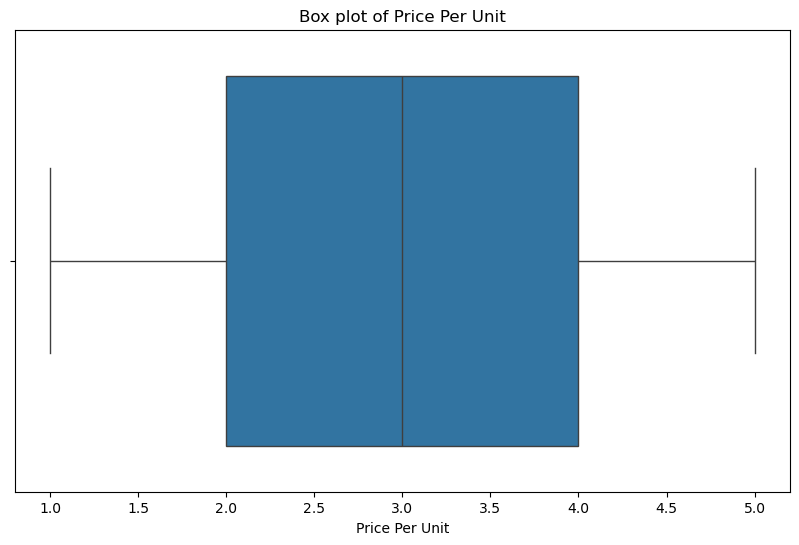

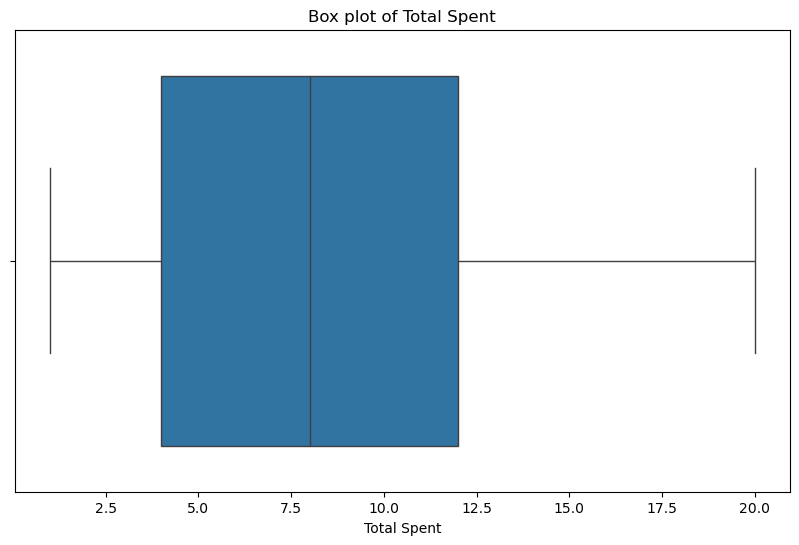

In [641]:
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=new_df[feature])
    plt.title(f'Box plot of {feature}')
    plt.show()

# Normalisasi dan Standardisasi Data

In [642]:
# Standardisasi fitur numerik
scaler = StandardScaler()
new_df[numeric_features] = scaler.fit_transform(new_df[numeric_features])

In [643]:
numeric_features

Index(['Quantity', 'Price Per Unit', 'Total Spent'], dtype='object')

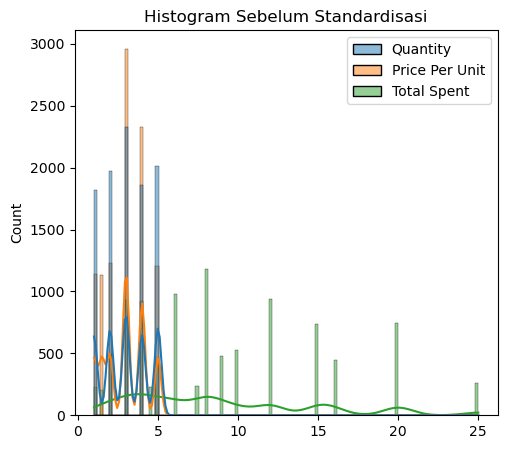

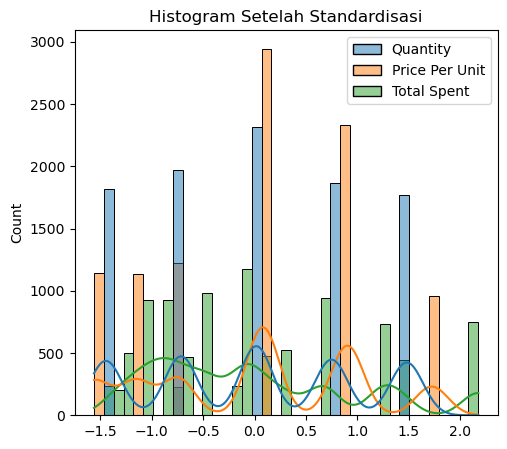

In [644]:
# Histogram Sebelum Standardisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[numeric_features], kde=True)
plt.title("Histogram Sebelum Standardisasi")
plt.show()

# Histogram Sesudah Standardisasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.histplot(new_df[numeric_features], kde=True)
plt.title("Histogram Setelah Standardisasi")
plt.show()

# Menangani Duplikasi Data

In [645]:
# Mengidentifikasi baris duplikat
duplicates = new_df.duplicated()
 
print("Baris duplikat:")
print(new_df[duplicates])

Baris duplikat:
      Quantity  Price Per Unit  Total Spent      Item  Payment Method  \
28    1.480261        0.902585     2.176610  Smoothie     Credit Card   
46    0.748432        0.080934     0.669095     Juice  Digital Wallet   
47    1.480261        0.080934     1.234413     Juice  Digital Wallet   
56    1.480261        0.080934     1.234413      Cake  Digital Wallet   
58    0.748432        0.902585     1.422852  Sandwich            Cash   
...        ...             ...          ...       ...             ...   
9995 -0.715225       -0.740718    -0.838421    Coffee  Digital Wallet   
9996  0.016603        0.080934    -1.026861     Juice  Digital Wallet   
9997  0.748432       -0.740718    -0.084663    Coffee  Digital Wallet   
9998  0.016603        0.080934    -1.026861    Cookie  Digital Wallet   
9999  0.016603        0.902585     0.669095  Sandwich            Cash   

      Location  
28    Takeaway  
46    In-store  
47    Takeaway  
56    Takeaway  
58    Takeaway  
...  

In [646]:
# Menghapus baris duplikat
# new_df = new_df.drop_duplicates()
 
# print("DataFrame setelah menghapus duplikat:")
# print(new_df)

# Mengonversi Tipe Data

In [647]:
# Seleksi kolom kategorikal
category_features = new_df.select_dtypes(include="object").columns
new_df[category_features]

# juice = (new_df['Item' == 'Juice']).sum()
# cake = (new_df['Item' == 'Cake']).sum()
# cookie = (new_df['Item' == 'Cookie']).sum()

# print(f'Juice: {juice}')
# print(f'Cake: {cake}')
# print(f'Cookie: {cookie}')

,Item,Payment Method,Location
0,Juice,Credit Card,Takeaway
1,Cake,Cash,In-store
2,Cookie,Credit Card,In-store
3,Salad,Digital Wallet,Takeaway
4,Coffee,Digital Wallet,In-store
...,...,...,...
9995,Coffee,Digital Wallet,Takeaway
9996,Juice,Digital Wallet,Takeaway
9997,Coffee,Digital Wallet,Takeaway
9998,Cookie,Digital Wallet,Takeaway


## One Hot Encoding

In [648]:
# One hot encoding
df_one_hot = pd.get_dummies(new_df, columns=category_features)
df_one_hot

,Quantity,Price Per Unit,Total Spent,Item_Cake,Item_Coffee,Item_Cookie,Item_Juice,Item_Salad,Item_Sandwich,Item_Smoothie,Item_Tea,Payment Method_Cash,Payment Method_Credit Card,Payment Method_Digital Wallet,Location_In-store,Location_Takeaway
0,-0.715225,-0.740718,-0.838421,False,False,False,True,False,False,False,False,False,True,False,False,True
1,0.748432,0.080934,0.669095,True,False,False,False,False,False,False,False,True,False,False,True,False
2,0.748432,-1.562369,-0.084663,False,False,True,False,False,False,False,False,False,True,False,True,False
3,-0.715225,1.724236,0.292216,False,False,False,False,True,False,False,False,False,False,True,False,True
4,-0.715225,-0.740718,-0.838421,False,True,False,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.715225,-0.740718,-0.838421,False,True,False,False,False,False,False,False,False,False,True,False,True
9996,0.016603,0.080934,-1.026861,False,False,False,True,False,False,False,False,False,False,True,False,True
9997,0.748432,-0.740718,-0.084663,False,True,False,False,False,False,False,False,False,False,True,False,True
9998,0.016603,0.080934,-1.026861,False,False,True,False,False,False,False,False,False,False,True,False,True


## Label Encoding

In [649]:
# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()
df_lencoder = pd.DataFrame(new_df)

for col in category_features:
    df_lencoder[col] = label_encoder.fit_transform(new_df[col])
 
# Menampilkan hasil
df_lencoder

,Quantity,Price Per Unit,Total Spent,Item,Payment Method,Location
0,-0.715225,-0.740718,-0.838421,3,1,1
1,0.748432,0.080934,0.669095,0,0,0
2,0.748432,-1.562369,-0.084663,2,1,0
3,-0.715225,1.724236,0.292216,4,2,1
4,-0.715225,-0.740718,-0.838421,1,2,0
...,...,...,...,...,...,...
9995,-0.715225,-0.740718,-0.838421,1,2,1
9996,0.016603,0.080934,-1.026861,3,2,1
9997,0.748432,-0.740718,-0.084663,1,2,1
9998,0.016603,0.080934,-1.026861,2,2,1


In [650]:
df_lencoder.head()

,Quantity,Price Per Unit,Total Spent,Item,Payment Method,Location
0,-0.715225,-0.740718,-0.838421,3,1,1
1,0.748432,0.080934,0.669095,0,0,0
2,0.748432,-1.562369,-0.084663,2,1,0
3,-0.715225,1.724236,0.292216,4,2,1
4,-0.715225,-0.740718,-0.838421,1,2,0


# EDA dan ExDA

In [651]:
# Menghitung jumlah dan persentase missing values di setiap kolom
missing_values = df_lencoder.isnull().sum()
missing_percentage = (missing_values / len(df_lencoder)) * 100
 
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values(by='Missing Values', ascending=False)
 
missing_data[missing_data['Missing Values'] > 0]  # Menampilkan kolom dengan missing values

,Missing Values,Percentage


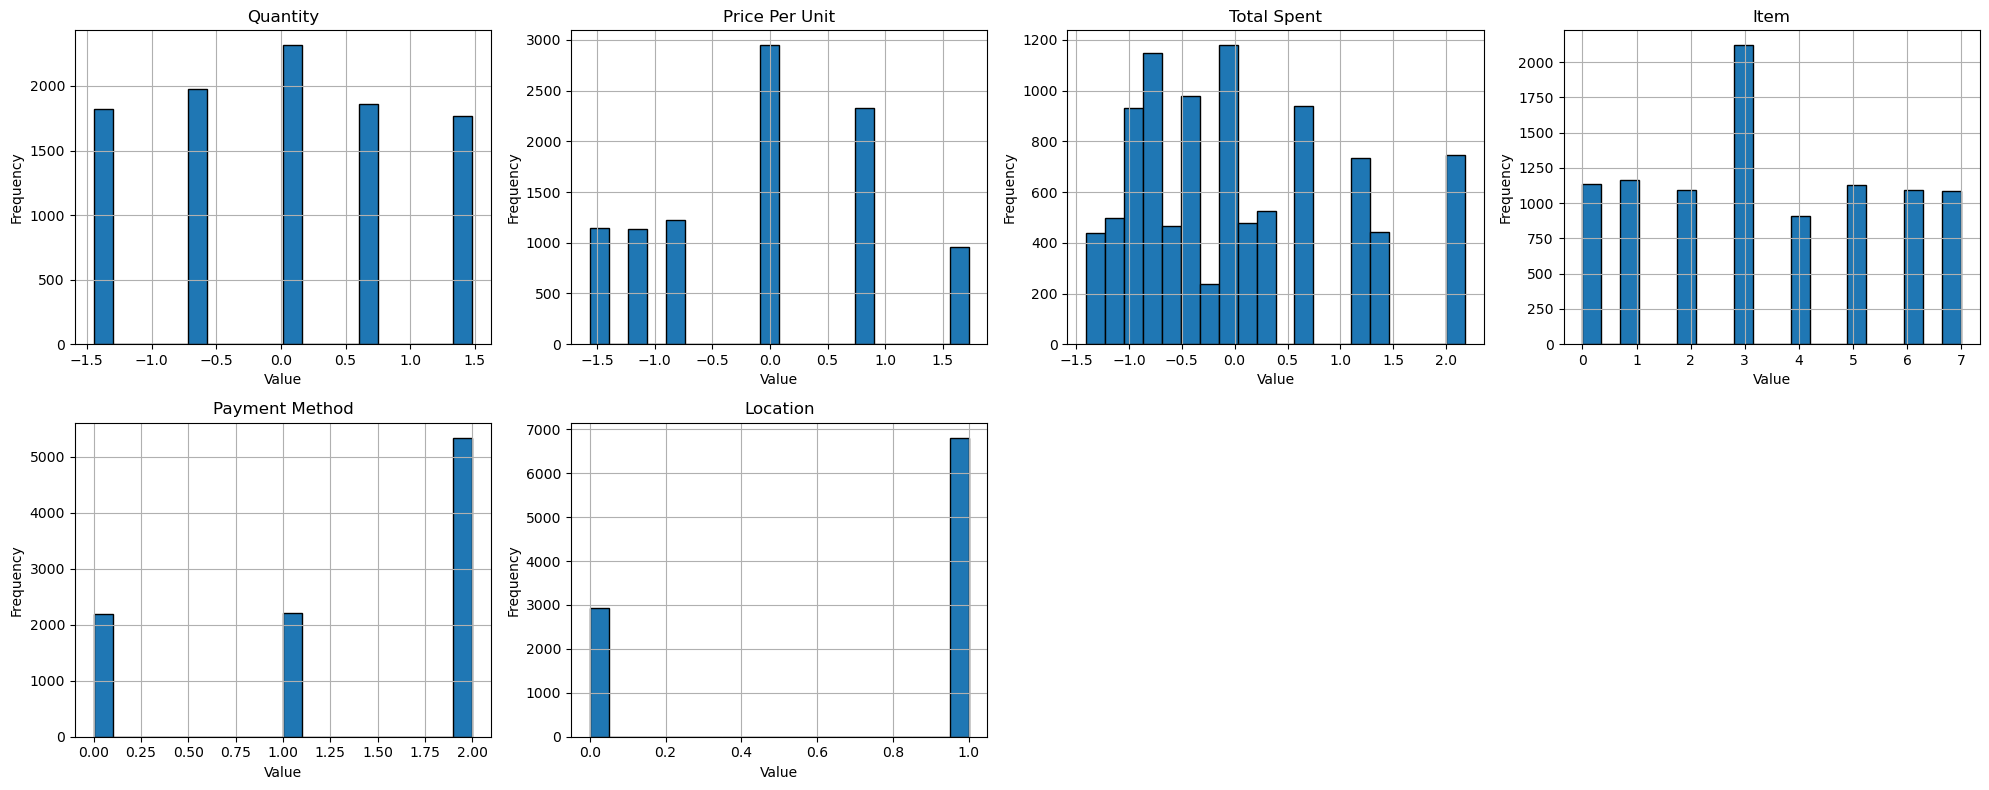

In [652]:
# Menghitung jumlah variabel
num_vars = df_lencoder.shape[1]

# Menentukan jumlah baris dan kolom untuk grid subplot
n_cols = 4  # Jumlah kolom yang diinginkan
n_rows = -(-num_vars // n_cols)  # Ceiling division untuk menentukan jumlah baris

# Membuat subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

# Flatten axes array untuk memudahkan iterasi jika diperlukan
axes = axes.flatten()

# Plot setiap variabel
for i, column in enumerate(df_lencoder.columns):
    df_lencoder[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
 
# Menghapus subplot yang tidak terpakai (jika ada)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
 
# Menyesuaikan layout agar lebih rapi
plt.tight_layout()
plt.show()

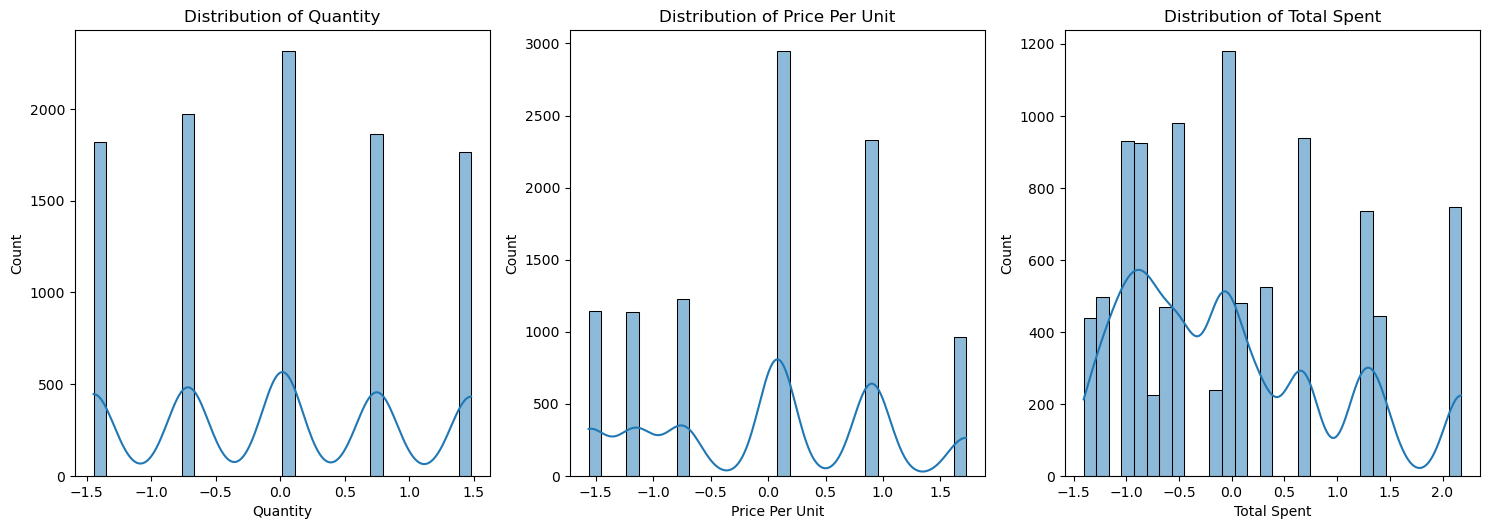

In [653]:
# Visualisasi distribusi data untuk beberapa kolom
columns_to_plot = ['Quantity', 'Price Per Unit', 'Total Spent',]

plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_lencoder[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
 
plt.tight_layout()
plt.show()

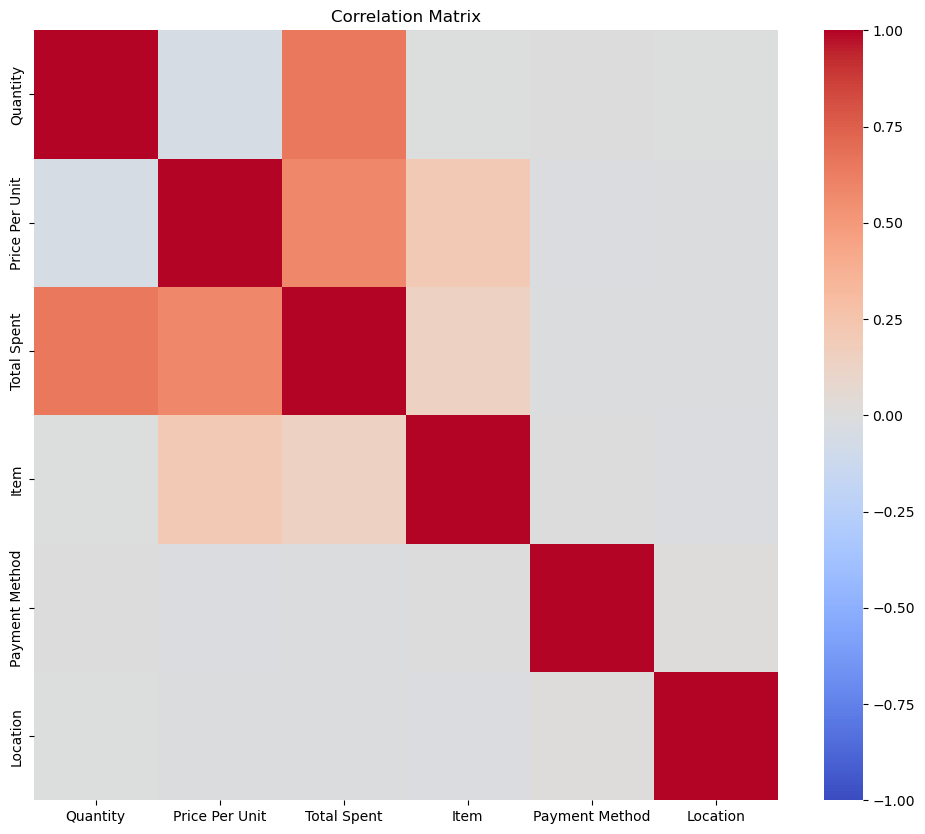

In [654]:
# Visualisasi korelasi antar variabel numerik
plt.figure(figsize=(12, 10))
correlation_matrix = df_lencoder.corr()
 
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

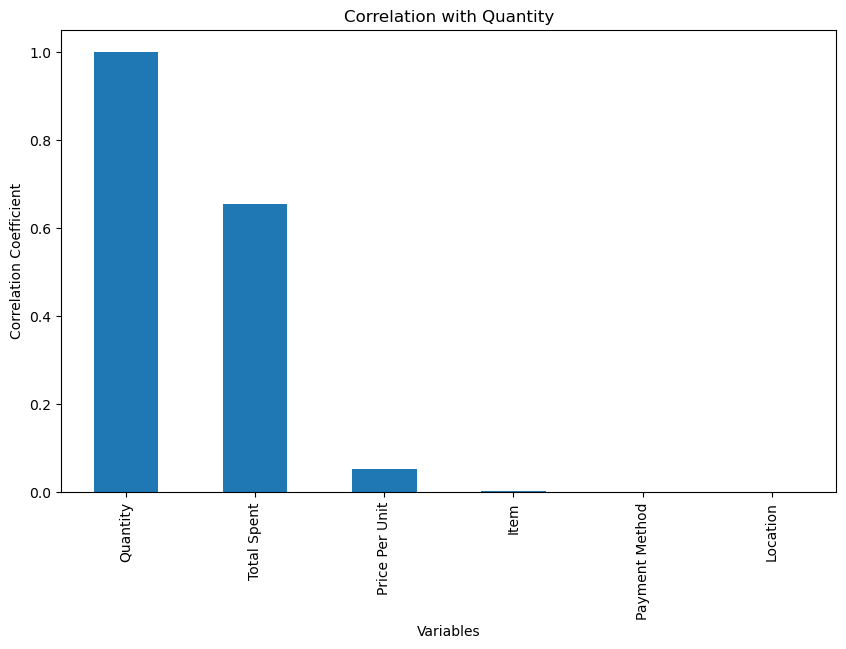

In [655]:
# Menghitung korelasi antara variabel target dan semua variabel lainnya
target_corr = df_lencoder.corr()['Quantity']
 
# (Opsional) Mengurutkan hasil korelasi berdasarkan korelasi
target_corr_sorted = target_corr.abs().sort_values(ascending=False)
 
plt.figure(figsize=(10, 6))
target_corr_sorted.plot(kind='bar')
plt.title(f'Correlation with Quantity')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

# Data Splitting

In [656]:
# Memisahkan fitur (x) dan target (y)
# kita akan menggunakan Total Spent sebagai target yang akan di prediksi
'''
- X: kumpulan atribut atau fitur dari dataset, yaitu semua kolom kecuali kolom target (pada kasus ini Total Spent).

- y: target atau label yang akan kita prediksi merupakan kolom yang ingin kita pisahkan (pada kasus ini Total Spent).

-test_size: persentase dari data yang akan digunakan sebagai test set. Misalnya, ketika Anda menentukan test_size=0.2, 20% dari data akan menjadi test set, dan 80% sisanya akan menjadi train set.

- random_state: parameter yang memastikan pemisahan data yang konsisten setiap kali fungsi tersebut dijalankan. Parameter ini mengontrol pengacakan saat membagi dataset sehingga dengan menetapkan random_state hasil pembagian data (train set dan test set) akan selalu sama. Hal ini penting untuk memastikan eksperimen yang dapat direproduksi dan evaluasi model yang konsisten. Namun, parameter ini juga dapat memiliki kekurangan yaitu model tidak akan menerima inputan baru yang mungkin akan lebih baik dari sebelumnya.

Ketika Anda menjalankan train_test_split, fungsi ini akan mengembalikan empat bagian data seperti berikut.

X_train: fitur untuk train set.
X_test: fitur untuk test set.
y_train: target untuk train set.
y_test: target untuk test set.

'''

X = df_lencoder.drop(columns=['Total Spent'])
y = df_lencoder['Total Spent']

# membagi dataset menjadi training dan testing 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# menghitung panjang/jumlah data 
print("Jumlah data: ",len(X))
# menghitung panjang/jumlah data pada x_train
print("Jumlah data latih: ",len(x_train))
# menghitung panjang/jumlah data pada x_test
print("Jumlah data test: ",len(x_test))

Jumlah data:  9741
Jumlah data latih:  7792
Jumlah data test:  1949


# Training Model

In [657]:
# Melatih model 1 dengan algoritma Least Angle Regression
lars = linear_model.Lars(n_nonzero_coefs=1).fit(x_train, y_train)

In [658]:
# Melatih model 2 dengan algoritma Linear Regression
LR = LinearRegression().fit(x_train, y_train)

In [659]:
# Melatih model 3 dengan algoritma Gradient Boosting Regressor
GBR = GradientBoostingRegressor(random_state=184)
GBR.fit(x_train, y_train)

GradientBoostingRegressor(random_state=184)

# Evaluasi Model

In [660]:
# Evaluasi pada model LARS
pred_lars = lars.predict(x_test)
mae_lars = mean_absolute_error(y_test, pred_lars)
mse_lars = mean_squared_error(y_test, pred_lars)
r2_lars = r2_score(y_test, pred_lars)
 
# Membuat dictionary untuk menyimpan hasil evaluasi
data = {
    'MAE': [mae_lars],
    'MSE': [mse_lars],
    'R2': [r2_lars]
}
 
# Konversi dictionary menjadi DataFrame
df_results = pd.DataFrame(data, index=['Lars'])
df_results

,MAE,MSE,R2
Lars,0.801646,0.950802,0.08748


In [661]:
# Evaluasi pada model Linear Regression
pred_LR = LR.predict(x_test)
mae_LR = mean_absolute_error(y_test, pred_LR)
mse_LR = mean_squared_error(y_test, pred_LR)
r2_LR = r2_score(y_test, pred_LR)
 
# Menambahkan hasil evaluasi LR ke DataFrame
df_results.loc['Linear Regression'] = [mae_LR, mse_LR, r2_LR]
df_results

,MAE,MSE,R2
Lars,0.801646,0.950802,0.08748
Linear Regression,0.310089,0.189312,0.81831


In [662]:
# Evaluasi pada model Gradient Boosting Regressor
pred_GBR = GBR.predict(x_test)
mae_GBR = mean_absolute_error(y_test, pred_GBR)
mse_GBR = mean_squared_error(y_test, pred_GBR)
r2_GBR = r2_score(y_test, pred_GBR)
 
# Menambahkan hasil evaluasi GBR ke DataFrame
df_results.loc['GradientBoostingRegressor'] = [mae_GBR, mse_GBR, r2_GBR]
df_results

,MAE,MSE,R2
Lars,0.801646,0.950802,0.087480
Linear Regression,0.310089,0.189312,0.818310
GradientBoostingRegressor,0.124535,0.087749,0.915784


# Menyimpan Model
Untuk menyimpan model yang telah dilatih, Anda dapat menggunakan modul joblib atau pickle pada Python. Kedua modul ini memungkinkan Anda untuk menyimpan model ke dalam sebuah file sehingga bisa digunakan kembali di masa mendatang tanpa perlu melatih ulang model. Mari kita bahas kedua cara tersebut secara saksama.

### 1. Joblib
Joblib adalah pilihan yang disarankan untuk menyimpan model scikit-learn karena lebih efisien dalam menyimpan objek model yang besar.

### 2. Pickle
Pickle adalah modul standar Python yang dapat digunakan untuk menyimpan hampir semua objek Python termasuk model machine learning.

In [663]:
# Joblib
joblib.dump(GBR, 'gbr_model.joblib')

['gbr_model.joblib']

In [664]:
# model + encoder
encoders = {}
for col in category_features:
    le = LabelEncoder()
    df_lencoder[col] = le.fit_transform(new_df[col])
    encoders[col] = le
    
joblib.dump((GBR, encoders), "gbr_model_encoded.joblib")

['gbr_model_encoded.joblib']

In [665]:
# model + encoder + scaler 
encoders = {}
for col in category_features:
    le = LabelEncoder()
    df_lencoder[col] = le.fit_transform(new_df[col])
    encoders[col] = le
    
joblib.dump((GBR, scaler, category_features, numeric_features, encoders), "gbr_model_encoded_scaler.joblib")


['gbr_model_encoded_scaler.joblib']

In [666]:
# LR model + encoder + scaler 
encoders = {}
for col in category_features:
    le = LabelEncoder()
    df_lencoder[col] = le.fit_transform(new_df[col])
    encoders[col] = le
    
joblib.dump((LR, scaler, category_features, numeric_features, encoders), "lr_model.joblib")


['lr_model.joblib']

In [667]:
# Menyimpan model ke dalam file
with open('gbr_model.pkl', 'wb') as file:
    pickle.dump(GBR, file)